In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Libraries**
Import the necessary libraries:

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters")

## **Extract Dataset**
**If the dataset as a zip file, you can unzip it directly in Colab:**

In [3]:
!unzip -q "/content/drive/MyDrive/fruits-360_dataset_100x100.zip" -d "/content/fruits_dataset"

## **Load and Explore the Dataset**
Once extracted, load the training and testing directories. The dataset is organized into subdirectories for each class.

In [4]:
# Define your data directories
train_dir = '/content/fruits_dataset/fruits-360/Training'
test_dir = '/content/fruits_dataset/fruits-360/Test'

# Check the number of classes (subdirectories)
classes = os.listdir(train_dir)
print(f"Number of Classes: {len(classes)}")
print(f"Classes: {classes[:10]}")  # Display the first 10 classes

Number of Classes: 141
Classes: ['Watermelon 1', 'Apple Granny Smith 1', 'Banana Red 1', 'Pear Red 1', 'Kaki 1', 'Beetroot 1', 'Apple Red Delicious 1', 'Tamarillo 1', 'Pear Williams 1', 'Kiwi 1']


## **Data Preprocessing and Augmentation**

In [5]:
# Define the image data generator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)
# Load testing data (no augmentation, only normalization)
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 56432 images belonging to 141 classes.
Found 14059 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


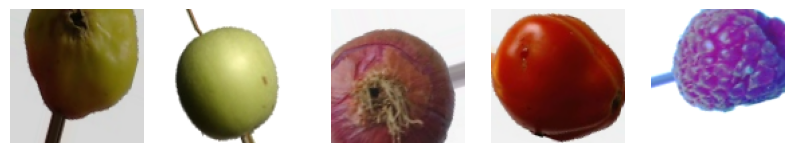

In [6]:
import matplotlib.pyplot as plt

# Get a batch of training data
x_batch, y_batch = next(train_generator)

# Plot the first 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [7]:
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {val_generator.samples}")

Training Samples: 56432
Validation Samples: 14059


In [8]:
print(f"Training samples % batch_size: {train_generator.samples % train_generator.batch_size}")
print(f"Validation samples % batch_size: {val_generator.samples % val_generator.batch_size}")

Training samples % batch_size: 16
Validation samples % batch_size: 11


### 🧮 Dynamically Calculate Steps Per Epoch
Use the number of samples and batch size from the `train_generator` and `val_generator` to calculate the `steps_per_epoch` for training and validation.

In [9]:
import math

# Dynamically calculate steps per epoch (including leftover samples)
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)

print(f"Steps per epoch (training): {steps_per_epoch}")
print(f"Steps per epoch (validation): {validation_steps}")

Steps per epoch (training): 1764
Steps per epoch (validation): 440


## **Monitor Class Imbalance**
If certain classes in your dataset are underrepresented, the model may perform well on majority classes but poorly on minority classes, leading to instability. Check the class distribution in your dataset:

In [10]:
from collections import Counter

class_counts = Counter(train_generator.classes)
print(class_counts)

Counter({51: 788, 112: 720, 31: 591, 32: 591, 75: 591, 88: 591, 125: 591, 128: 591, 130: 591, 137: 588, 98: 569, 14: 562, 29: 562, 48: 562, 94: 562, 102: 562, 91: 557, 133: 548, 13: 538, 129: 538, 97: 533, 103: 533, 104: 533, 79: 524, 80: 428, 108: 395, 1: 394, 4: 394, 6: 394, 8: 394, 9: 394, 12: 394, 15: 394, 25: 394, 26: 394, 30: 394, 33: 394, 34: 394, 35: 394, 52: 394, 55: 394, 58: 394, 66: 394, 76: 394, 77: 394, 85: 394, 87: 394, 89: 394, 90: 394, 105: 394, 106: 394, 113: 394, 120: 394, 122: 394, 124: 394, 132: 394, 17: 393, 11: 392, 18: 392, 20: 392, 24: 392, 27: 392, 37: 392, 38: 392, 45: 392, 50: 392, 53: 392, 54: 392, 57: 392, 59: 392, 61: 392, 62: 392, 65: 392, 67: 392, 68: 392, 69: 392, 70: 392, 71: 392, 74: 392, 86: 392, 93: 392, 96: 392, 99: 392, 100: 392, 107: 392, 109: 392, 119: 392, 121: 392, 123: 392, 126: 392, 127: 392, 5: 385, 3: 384, 78: 384, 84: 384, 131: 384, 136: 380, 138: 380, 0: 379, 56: 377, 64: 377, 44: 375, 46: 375, 63: 373, 60: 372, 22: 370, 40: 370, 135: 36

## **Build a Simple Classifier**
Here, we'll use a simple Multilayer Perceptron (MLP) or a Convolutional Neural Network (CNN). Since this is image data, a CNN is better suited.

In [11]:
from tensorflow.keras.regularizers import l2

# Build a model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Dense layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,800,877 (37.39 MB)

 Trainable params: 9,798,957 (37.38 MB)

 Non-trainable params: 1,920 (7.50 KB)

### ⚖️ Compute Class Weights
Class weights are calculated to handle class imbalance in the dataset. This ensures that underrepresented classes are given more importance during training.


In [12]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Optionally smooth weights
class_weight_dict = {k: v**0.5 for k, v in class_weight_dict.items()}

# Print class weights to verify
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0276223939642457, 1: 1.0078712430287862, 2: 1.0602985459831928, 3: 1.0209102228967688, 4: 1.0078712430287862, 5: 1.01958350339812, 6: 1.0078712430287862, 7: 1.0471447811799264, 8: 1.0078712430287862, 9: 1.0078712430287862, 10: 1.0786335972318655, 11: 1.0104390720135261, 12: 1.0078712430287862, 13: 0.8625058055454738, 14: 0.8438883803535555, 15: 1.0078712430287862, 16: 1.081782899108205, 17: 1.0091527073010067, 18: 1.0104390720135261, 19: 1.05439154433389, 20: 1.0104390720135261, 21: 1.05439154433389, 22: 1.0400454126709393, 23: 1.8574801023545822, 24: 1.0104390720135261, 25: 1.0078712430287862, 26: 1.0078712430287862, 27: 1.0104390720135261, 28: 1.8186975413004531, 29: 0.8438883803535555, 30: 1.0078712430287862, 31: 0.8229234239483812, 32: 0.8229234239483812, 33: 1.0078712430287862, 34: 1.0078712430287862, 35: 1.0078712430287862, 36: 1.05439154433389, 37: 1.0104390720135261, 38: 1.0104390720135261, 39: 1.05439154433389, 40: 1.0400454126709393, 41: 1.826259725857309

### 🔄 Step 4: Define Callbacks
Callbacks are used to optimize training. They include:
1. **EarlyStopping**: Stops training when the loss stops improving.
2. **ReduceLROnPlateau**: Reduces the learning rate when the loss plateaus.
3. **ModelCheckpoint**: Saves the model with the best accuracy during training.

In [13]:
callbacks = [
    EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.2,
        patience=3,
        lr=0.001
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='accuracy',
        save_best_only=True,
        mode='max'
    )
]

### 🚀 Train the Model
Use a `for` loop to train the model for 10 epochs. After every epoch:
- Reset the data generators (`train_generator.reset()` and `val_generator.reset()`) to avoid data interruptions.
- Store metrics like training/validation accuracy and loss for plotting later.

In [14]:
# Initialize lists to store metrics for plotting
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

# Train the model in a loop
for epoch in range(10):  # Train for 10 epochs
    train_generator.reset()
    val_generator.reset()

    # Train the model for 1 epoch at a time
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1,
        epochs=1
    )

    # Store metrics for plotting
    training_accuracy.append(history.history['accuracy'][0])
    validation_accuracy.append(history.history['val_accuracy'][0])
    training_loss.append(history.history['loss'][0])
    validation_loss.append(history.history['val_loss'][0])

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 260s 137ms/step - accuracy: 0.3563 - loss: 6.9600 - val_accuracy: 0.6244 - val_loss: 4.0346 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 227s 128ms/step - accuracy: 0.7226 - loss: 3.7830 - val_accuracy: 0.7613 - val_loss: 3.8329 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 229s 129ms/step - accuracy: 0.8004 - loss: 3.7242 - val_accuracy: 0.8722 - val_loss: 3.6580 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 229s 129ms/step - accuracy: 0.8310 - loss: 3.6934 - val_accuracy: 0.9118 - val_loss: 3.1780 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 231s 131ms/step - accuracy: 0.8583 - loss: 3.4540 - val_accuracy: 0.9178 - val_loss: 3.3084 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 231s 131ms/step - accuracy: 0.8759 - loss: 3.2534 - val_accuracy: 0.9505 - val_loss: 2.7421 - learning_rate: 0.0010
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 229s 129ms/step - accuracy: 0.8884 - loss: 2.9713 - val_accuracy: 0.9009 - val_loss: 2.

### 📊 Plot Training and Validation Metrics
After training, visualize the model's performance using accuracy and loss curves for training and validation datasets.

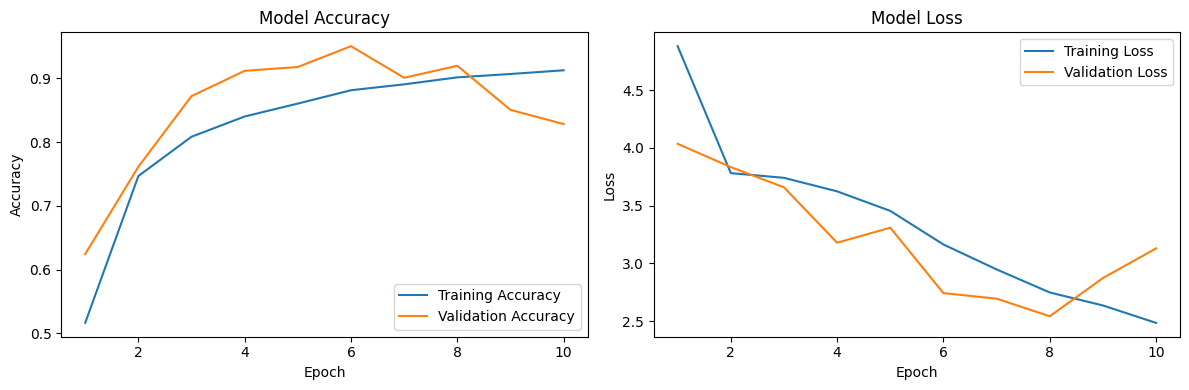

In [15]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 💾 Save the Best Model
Save the best-performing model during training using `ModelCheckpoint`. This ensures you can reload the model later for evaluation or deployment.

In [16]:
# Reload the best model
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')
print("Best model loaded successfully.")

Best model loaded successfully.


### 🧪 Evaluate the Model on the Test Set
Evaluate the final model using the test dataset to assess its performance on unseen data.

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8082 - loss: 3.3203
Test Accuracy: 83.57%
Test Loss: 3.1752


### 🔍 Predict on a Single Image
Use the trained model to predict the class of a single image. Display the image along with the predicted class label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


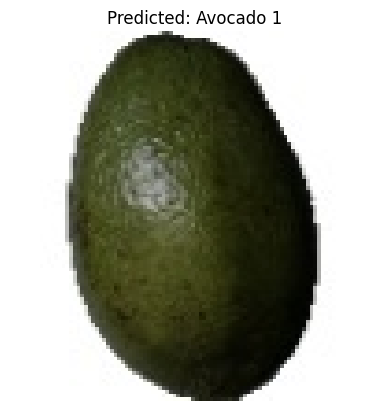

In [18]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = "/content/fruits_dataset/fruits-360/Test/Avocado 1/45_100.jpg"
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


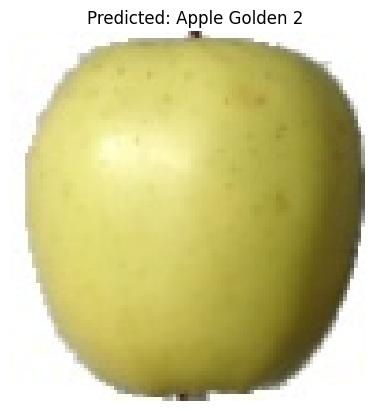

In [19]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = "/content/fruits_dataset/fruits-360/Test/Apple Golden 2/37_100.jpg"
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


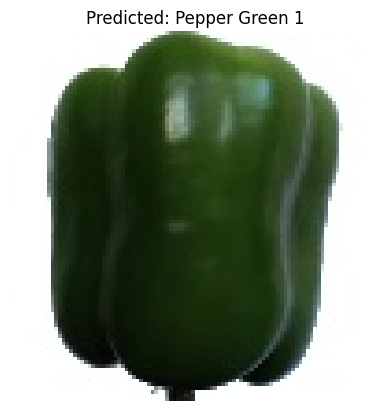

In [20]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = "/content/fruits_dataset/fruits-360/Test/Pepper Green 1/102_100.jpg"
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


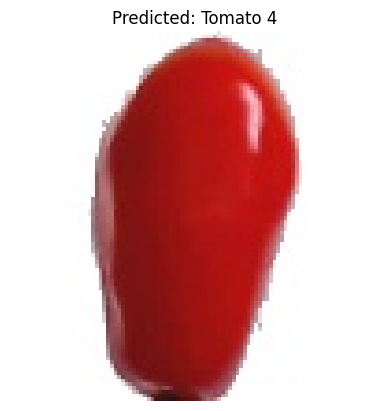

In [21]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = "/content/fruits_dataset/fruits-360/Test/Tomato 2/102_100.jpg"
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


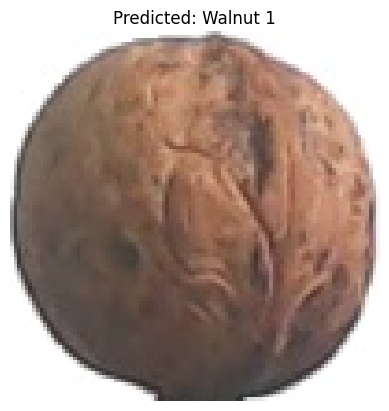

In [22]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a single image
img_path = "/content/fruits_dataset/fruits-360/Test/Walnut 1/105_100.jpg"
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
prediction = best_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

# Map the predicted class index to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()